In [1]:
import random, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from optimize_portfolio import optimize_portfolio

In [2]:
"""
Data import
"""
asset_index = pd.read_csv("data/aidx_eod_prices.csv")

# data sorting/longer than 800 days
grouped_asset = asset_index.groupby("S_IRDCODE")
asset_dfs = {ird_code: group for ird_code, group in grouped_asset if len(group) >= 800}
for ird_code, grouped_df in asset_dfs.items():
    grouped_df['TRADE_DT'] = pd.to_datetime(grouped_df['TRADE_DT'], format='%Y%m%d')
    grouped_df.sort_values(by='TRADE_DT', inplace=True)

In [3]:
"""
Parameters
"""

MODEL_TYPE = 'MVO' # optimisation model: MVO, RP, RB
BACKTEST_DAY = 180 # lookback period
TARGET_RETURN = 0.0 # target return
RISK_FREE_RATE = 0.02 # risk-free rate

NUM_LIMIT = 10 # assets amount limitation range
CORR_LIMIT = 0.5 # assets' correlation limiation


In [4]:
"""
Asset sampling
"""

def sample(num_limit, asset_dfs, corr_limit):
    index_list = random.sample(list(asset_dfs.keys()), num_limit)
    
    def is_non_related(index_list):
        for i in range(0, len(index_list)):
            for j in range(i+1, len(index_list)):
                i_df = asset_dfs[index_list[i]]
                j_df = asset_dfs[index_list[j]]
                min_length = min(len(i_df['PCHG']), len(j_df['PCHG']))
                corr, _ = scipy.stats.spearmanr(i_df['PCHG'].iloc[:min_length], j_df['PCHG'].iloc[:min_length])
                if corr > corr_limit:
                    return False
        return True
    
    while is_non_related(index_list) == False:
        index_list = random.sample(list(asset_dfs.keys()), num_limit)
    
    return index_list

In [5]:
"""
Asset data process
"""

# assets pool
# unique_assets = sample(NUM_LIMIT, asset_dfs, CORR_LIMIT)
unique_assets = ['930963.CSI', '483051.CNI', '930923.CSI', 'CN5122.CNI', 'h20856.CSI', 'h30467.CSI', 'h30188.CSI', 'h01179.CSI', '931722USD210.CSI', 'h21094.CSI']

# assets dataframe
asset_index_copy = asset_index.copy()
asset_index_copy['TRADE_DT'] = pd.to_datetime(asset_index_copy['TRADE_DT'], format='%Y%m%d')
asset_index_copy.sort_values(by='TRADE_DT', inplace=True)
asset_index_copy.set_index('TRADE_DT', inplace=True)
asset_index_copy = asset_index_copy.pivot(columns='S_IRDCODE', values='CLOSE').ffill()[unique_assets].dropna()
asset_index_copy = asset_index_copy.tail(BACKTEST_DAY)

print(unique_assets)
print(asset_index_copy)

['930963.CSI', '483051.CNI', '930923.CSI', 'CN5122.CNI', 'h20856.CSI', 'h30467.CSI', 'h30188.CSI', 'h01179.CSI', '931722USD210.CSI', 'h21094.CSI']
S_IRDCODE   930963.CSI  483051.CNI  930923.CSI  CN5122.CNI  h20856.CSI  \
TRADE_DT                                                                 
2023-04-21   3190.3941   6229.9727   1008.5881   1861.4333   4745.8684   
2023-04-24   3176.5544   6119.3960   1004.5533   1839.4121   4731.2796   
2023-04-25   3092.1949   6140.7562    984.7820   1815.8954   4651.5579   
2023-04-26   3131.3668   6159.0304    994.4742   1844.0735   4686.3124   
2023-04-27   3132.1461   6115.8147    997.5691   1823.0461   4684.3155   
...                ...         ...         ...         ...         ...   
2024-01-02   2800.8503   5313.8320    800.8711   1594.6583   4116.1149   
2024-01-03   2800.8503   5247.4035    795.7280   1620.8221   4086.9111   
2024-01-04   2800.8503   5195.1772    795.6865   1625.9875   4121.6043   
2024-01-05   2800.8503   5131.0413    7

In [6]:
"""
Fitness Function (Regularization - Optional)
"""

# Fitness Function
def evaluate(individual):
    # Select assets based on the individual's binary vector
    selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]

    # If selected assets are empty (might be caused by mutation, crossover),
    # Set output to extreme situation
    if len(selected_assets) == 0:
        return -99999, -99999, 99999 # min return/sharpe, max volatility
    
    # Filter out the dataframe for selected assets
    tmp_close = asset_index_copy[asset_index_copy.columns[asset_index_copy.columns.isin(selected_assets)]]

    # Model output (new weights)
    new_weights, evaluation = optimize_portfolio(model_type=MODEL_TYPE, tmp_close=tmp_close,
                                                 target_return=TARGET_RETURN, risk_free_rate=RISK_FREE_RATE)

    # Expected Return, Sharpe Ratio, Volatility
    expected_return, sharpe_ratio, volatility = evaluation

    return expected_return, sharpe_ratio, volatility

In [7]:
"""
GA Setup
"""

# Objective Setup: MAX(return, sharpe); MIN(volatility) [Equally-weighed]
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Individual Creation Func (Clustering - Optional)
def create_individual():
    individual = [random.randint(0, 1) for _ in range(len(unique_assets))]
    if sum(individual) == 0:  # If all zeros, randomly set one to 1
        individual[random.randint(0, len(unique_assets) - 1)] = 1
    return individual

# GA Initialization
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [8]:
"""
GA Algorithms Registration (Crossover, Mutation, Selection)
"""

# NSGA-II
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selNSGA2)

In [9]:
"""
GA Stopping Criteria (Optional)
"""

# Method 1 - Stable Pareto Front
def is_pareto_stable(history, gen, stability_threshold=10):
    if gen < stability_threshold:
        return False
    last_fronts = history[-stability_threshold:]
    return all(last_fronts[-1] == front for front in last_fronts)

# Method 2 - Stable Pareto Front Size
def is_pareto_size_stable(history, stability_threshold=30, relative_range=0.05):
    if len(history) < stability_threshold:
        return False

    sizes = [len(front) for front in history[-stability_threshold:]]
    max_size = max(sizes)
    min_size = min(sizes)

    if max_size == 0:
        return False

    size_fluctuation = (max_size - min_size) / max_size
    return size_fluctuation <= relative_range

# Method 3 - No Significant Improvements
def no_significant_improvements(history, gen, stability_threshold=30, improvement_threshold=0.01):
    if gen < stability_threshold:
        return False
    recent_hvs = history[-stability_threshold:]
    return all((hv - min(recent_hvs)) / hv < improvement_threshold for hv in recent_hvs)

In [16]:
from deap.algorithms import varAnd

""""
Run Genetic Algorithm
"""

# Running the GA
def run_ga(pop_size, num_generations):
    # Records
    pop = toolbox.population(n=pop_size)
    hof = tools.ParetoFront()
    logbook = tools.Logbook()
    stats = tools.Statistics(lambda ind: ind.fitness.values)

    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    # Refactor eaSimple with stopping criteria
    def eaSimpleMod(cxpb, mutpb):
        logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

        hv_history = [] # improvement record (using hypervolume)
        pareto_history = [] # pareto record

        # Begin the generational process
        for gen in range(num_generations):
            # Select the next generation individuals
            offspring = toolbox.select(pop, len(pop))

            # Vary the pool of individuals
            offspring = varAnd(offspring, toolbox, cxpb, mutpb)

            # Evaluate the individuals with an invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

            # Update the hall of fame with the generated individuals
            if hof is not None:
                hof.update(offspring)
                pareto_history.append(list(hof)) # update the pareto history

            # Replace the current population by the offspring
            pop[:] = offspring

            # Append the current generation statistics to the logbook
            record = stats.compile(pop) if stats else {}
            logbook.record(gen=gen, nevals=len(invalid_ind), **record)
            print(logbook.stream)

            # Calculate hypervolume of halloffame
            modified_front = [] # negate third objective (min volatility)
            for ind in hof:
                modified_ind = toolbox.clone(ind) # clone individual
                modified_values = [ind.fitness.values[0], ind.fitness.values[1], -ind.fitness.values[2]]
                modified_ind.fitness.values = tuple(modified_values)
                modified_front.append(modified_ind)
            hv = tools.hypervolume(modified_front)
            hv_history.append(hv)

            # Stopping Criteria
            if no_significant_improvements(hv_history, gen) and is_pareto_size_stable(pareto_history):
                print(f"Stopping GA at generation {gen}")
                break

    # Execute evolutionary algorithm
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=hof,  verbose=True) # without stopping criteria
    eaSimpleMod(0.7, 0.2) # with stopping criteria

    return pop, hof, stats, logbook

# GA run
population, pareto_front, stats, logbook = run_ga(50, 200)  # X individuals, Y generations

gen	nevals	avg                                              	std                                           	min                                              	max                                              
0  	50    	[-1.83517851e-01 -1.54671044e-03  1.53128133e+02]	[2.91250259e-02 5.92415037e-04 7.45673098e+01]	[-2.60313469e-01 -3.24952528e-03  7.18267070e+01]	[-1.25124639e-01 -3.21317624e-04  5.52306708e+02]
1  	42    	[-1.83992525e-01 -1.58006873e-03  1.55352148e+02]	[3.31991032e-02 7.12566183e-04 8.12655086e+01]	[-2.60313469e-01 -4.30771023e-03  6.42300129e+01]	[-9.17882369e-02 -3.21317624e-04  5.52306708e+02]
2  	37    	[-1.82854535e-01 -1.54272974e-03  1.54883711e+02]	[3.30148266e-02 7.04783006e-04 7.37767974e+01]	[-2.60210169e-01 -4.30771023e-03  5.33659064e+01]	[-9.17882369e-02 -3.21317624e-04  5.52306708e+02]
3  	39    	[-1.81298489e-01 -1.55085629e-03  1.44974253e+02]	[3.30863041e-02 6.73540717e-04 4.35739150e+01]	[-2.60210169e-01 -4.30771023e-03  5.33659064e+01]	[-1.103754

In [11]:
"""
Pareto Front
"""

pareto_front = [ind for ind in pareto_front if not all(x == 0 for x in ind)]

# Retrieve Weights/evaluations
def get_weights_evaluations(individual):
    selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]
    tmp_close = asset_index_copy[asset_index_copy.columns[asset_index_copy.columns.isin(selected_assets)]]
    new_weights, evaluation = optimize_portfolio(model_type=MODEL_TYPE, tmp_close=tmp_close,
                                                 target_return=TARGET_RETURN, risk_free_rate=RISK_FREE_RATE)
    return new_weights, evaluation

# Retrieve and store weights/evaluations
individual_weights = {str(ind): get_weights_evaluations(ind)[0] for ind in pareto_front}
individual_evaluations = {str(ind): get_weights_evaluations(ind)[1] for ind in pareto_front}

# Output
for i, ind in enumerate(pareto_front):
    print(f"Pareto Front {i}")
    print(f"Individual: {ind}")
    print(f"Weights: {individual_weights[str(ind)]}")
    print(f"Evaluations: {individual_evaluations[str(ind)]}")
    print("")

Pareto Front 0
Individual: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Weights: [1.0]
Evaluations: (-0.02611059477079769, -0.0006337282527582979, 72.76083174468181)

Pareto Front 1
Individual: [0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
Weights: [0.5, 0.5]
Evaluations: (-0.031452354473764266, -0.0009892943686258392, 52.00914521047279)

Pareto Front 2
Individual: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Weights: [1.0]
Evaluations: (-0.03679411417673084, -0.0013029098549373938, 43.59020999151155)

Pareto Front 3
Individual: [0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Evaluations: (-0.07345686267400982, -0.0004356823081676604, 214.5069031309977)

Pareto Front 4
Individual: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Weights: [0.5, 0.5]
Evaluations: (-0.09178823692264931, -0.00036318533755787274, 307.7994218443252)

Pareto Front 5
Individual: [1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Weights: [0.25, 0.25, 0.25, 0.25]
Evaluations: (-0.09675689819440456, -0.0006309114034989643, 185.060687676405

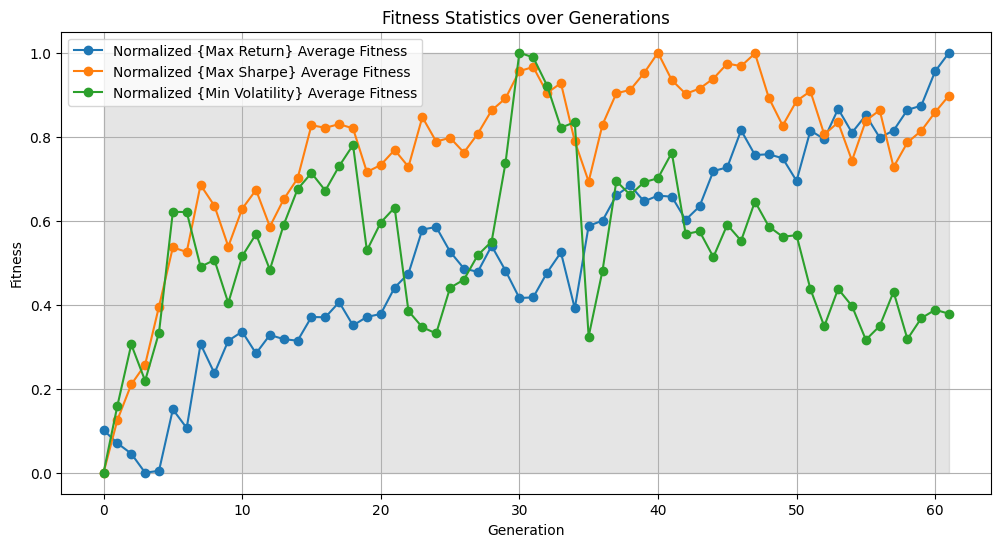

In [12]:
"""
Evolutionary Visualization
"""

# Extracting the statistics
gen = logbook.select("gen")
avg_fitness = logbook.select("avg")
std_fitness = logbook.select("std")
min_fitness = logbook.select("min")
max_fitness = logbook.select("max")

# Normalization function
def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# Normalizing the average fitness for each objective
normalized_avg_fitness = [normalize([fit[i] for fit in avg_fitness]) for i in range(len(avg_fitness[0]))]

# Plotting for multiple objectives
plt.figure(figsize=(12, 6))

# Each objective (Avg)
plt.plot(gen, normalized_avg_fitness[0], label=f'Normalized {{Max Return}} Average Fitness', marker='o')
plt.plot(gen, normalized_avg_fitness[1], label=f'Normalized {{Max Sharpe}} Average Fitness', marker='o')
plt.plot(gen, normalized_avg_fitness[2], label=f'Normalized {{Min Volatility}} Average Fitness', marker='o')

# Misc
plt.fill_between(gen, 0, 1, alpha=0.2, color='grey')
plt.title('Fitness Statistics over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()
